<a href="https://colab.research.google.com/github/V3ence/DS_education/blob/main/project_DIPLOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Тема дилома: Прогнозирование курсов валют и акций

In [1]:
from warnings import filterwarnings

In [2]:
filterwarnings("ignore")

Загрузим курс валютной пары EURUSD

In [136]:
import statsmodels.graphics.tsaplots as sgt
import pandas as pd
#!pip install pandas_ta
import yfinance as yf
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

symbol = 'EURUSD=X'
start_date = '2013-01-04'
end_date = '2023-11-07'
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-04,1.303101,1.306380,1.300052,1.303271,1.303271,0
2013-01-07,1.306848,1.309929,1.302060,1.306745,1.306745,0
2013-01-08,1.312336,1.313819,1.306762,1.312508,1.312508,0
2013-01-09,1.308387,1.309500,1.303900,1.308233,1.308233,0
2013-01-10,1.305364,1.321598,1.304104,1.305483,1.305483,0
...,...,...,...,...,...,...
2023-10-31,1.061504,1.066906,1.056759,1.061504,1.061504,0
2023-11-01,1.057910,1.058078,1.052288,1.057910,1.057910,0
2023-11-02,1.058705,1.067008,1.058425,1.058705,1.058705,0


In [137]:
#Будем работать только с одним признаком Close
data.drop (data.columns [[0, 1, 2, 4, 5]], axis= 1 , inplace= True )

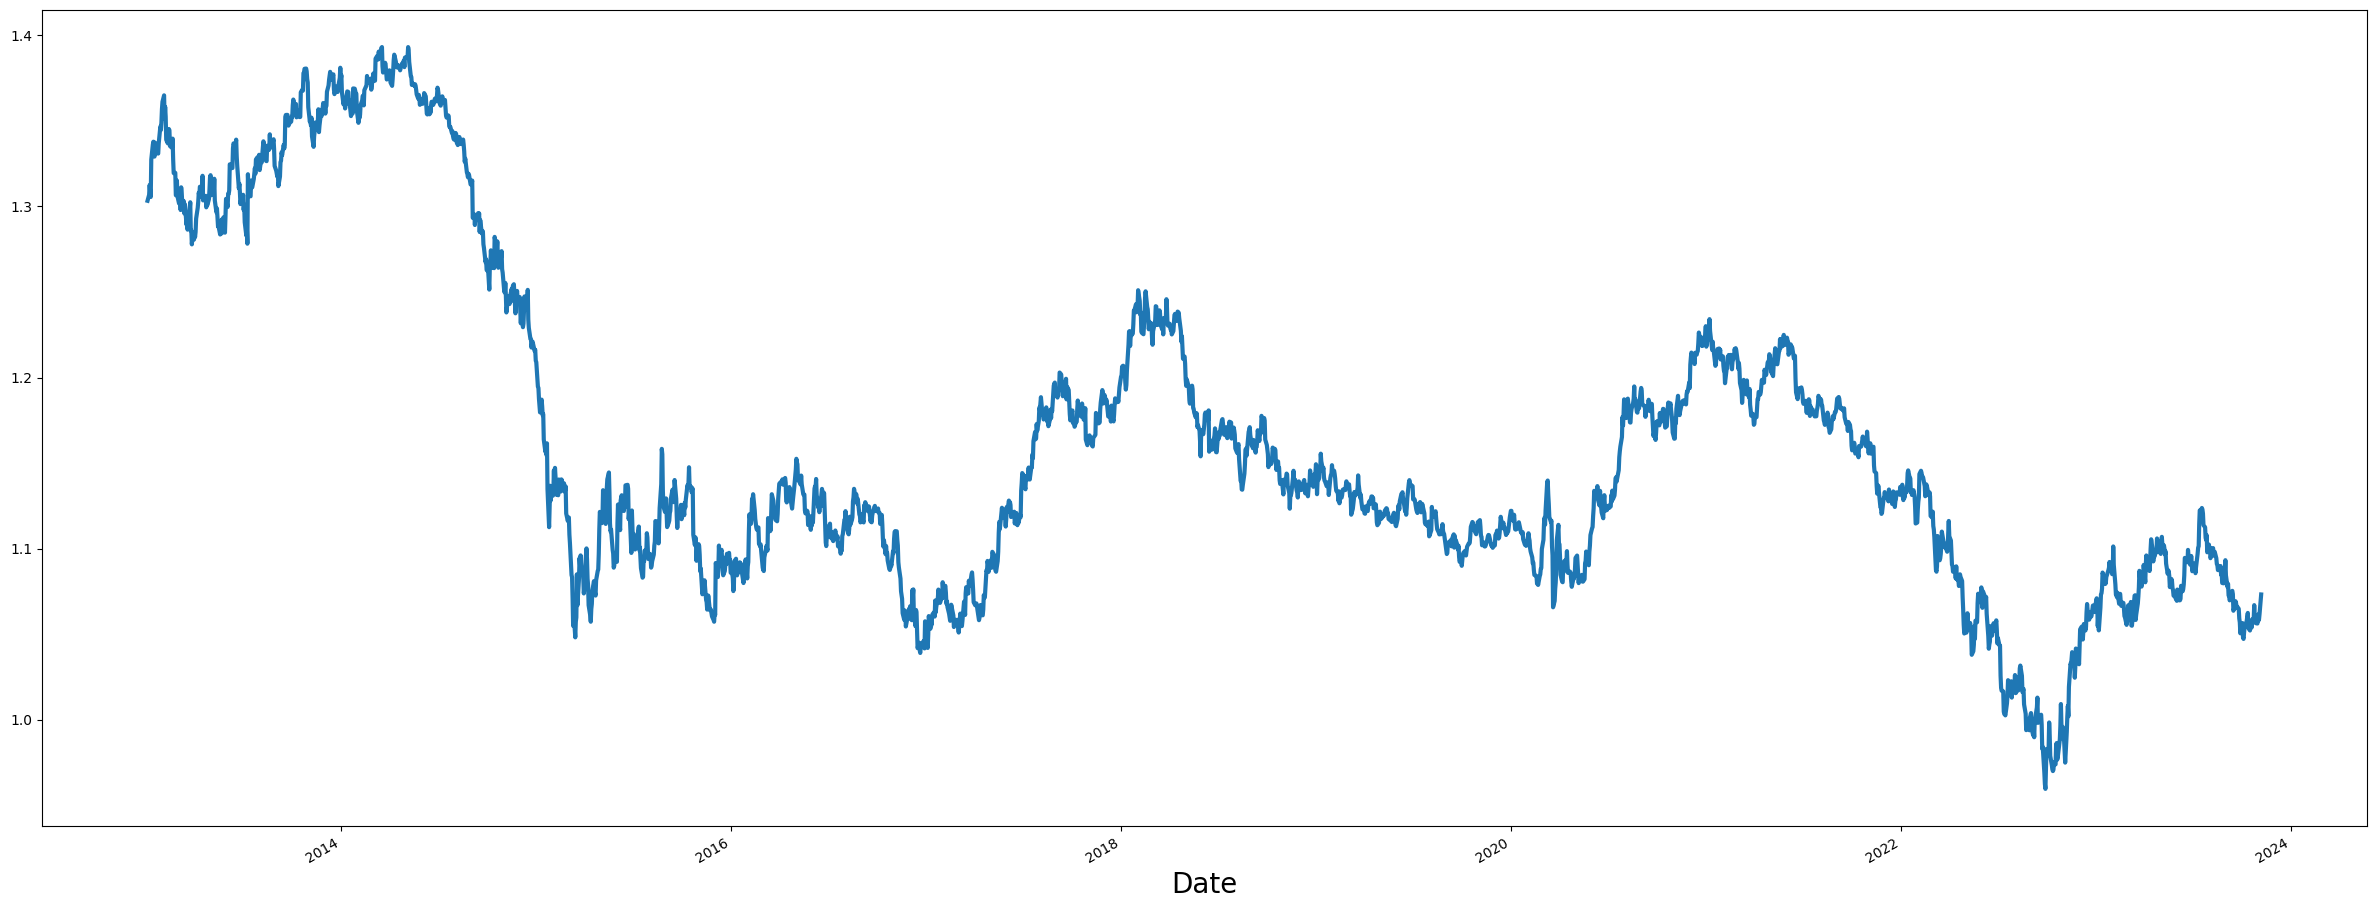

In [6]:
#Отрисуем курс на графике
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.Close.plot()
plt.show()

In [138]:
# Интерполируем данные, внеся выходные и праздники
data = data.asfreq(freq='d')
data[['Close']] = data[['Close']].interpolate(method='linear')

In [139]:
data

,Close
Date,
2013-01-04,1.303271
2013-01-05,1.304429
2013-01-06,1.305587
2013-01-07,1.306745
2013-01-08,1.312508
...,...
2023-11-02,1.058705
2023-11-03,1.061909
2023-11-04,1.065678


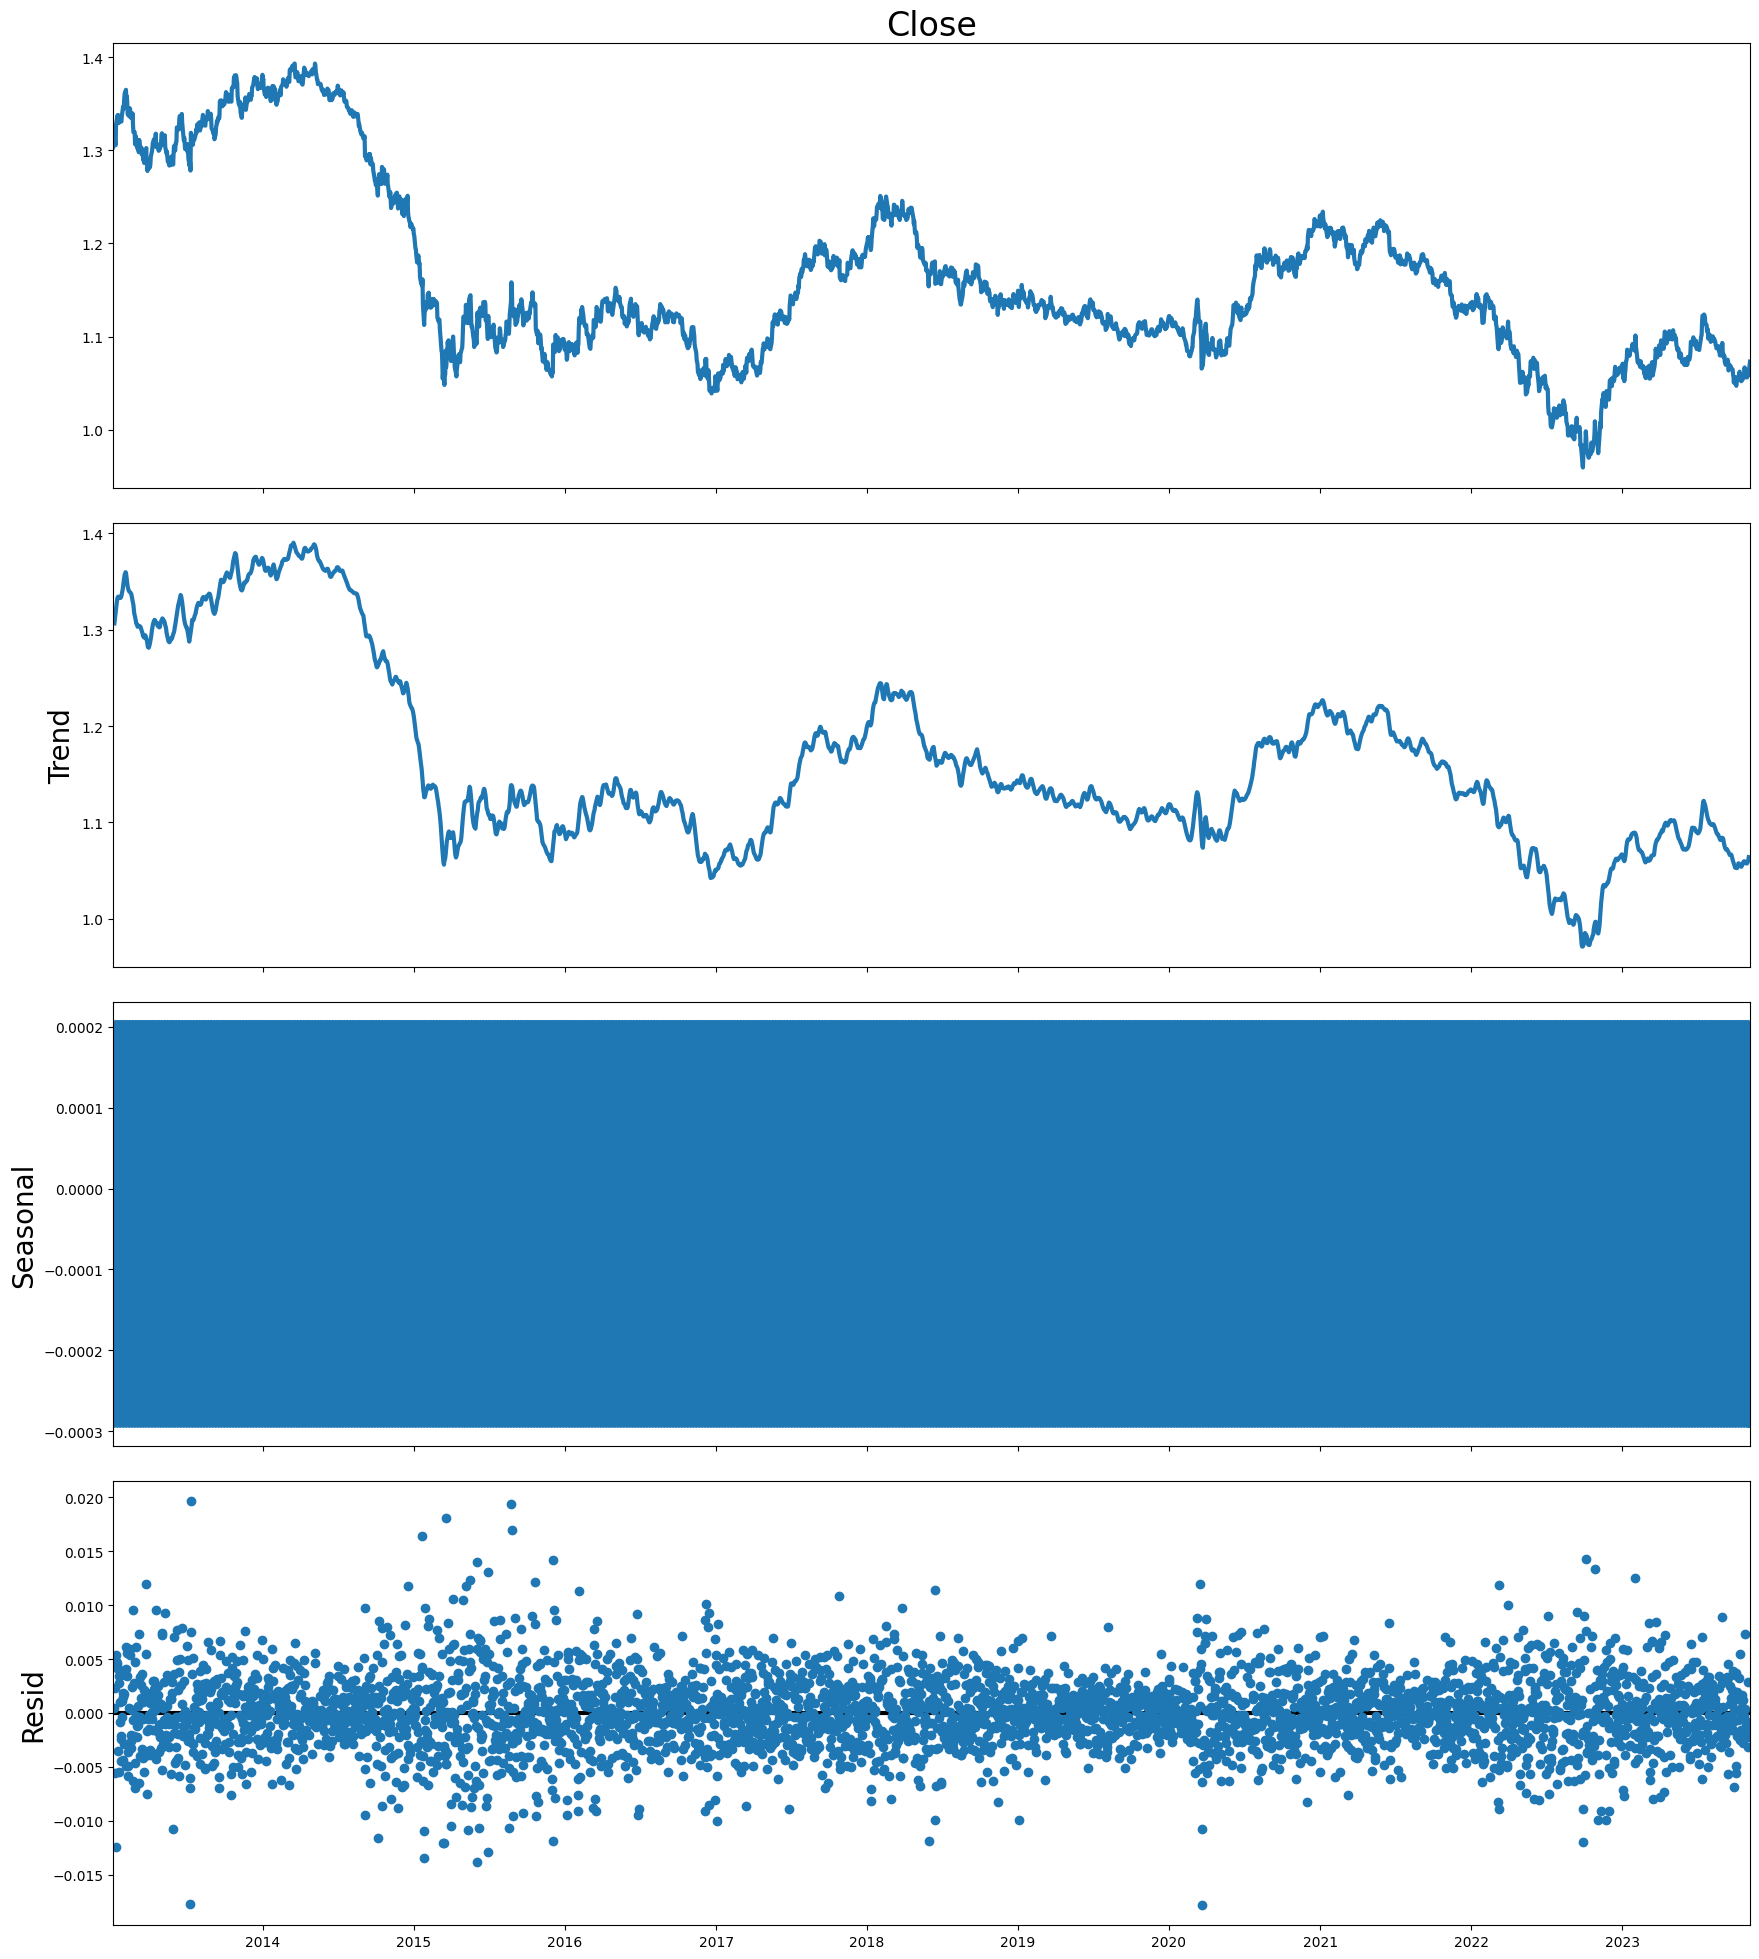

In [9]:
#Выделим состовлющие тренда, сезонности, остатков
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(data.Close)
result.plot()
plt.show()

In [140]:
# Разобъем данные на train и test
train_df = data.iloc[:-14]
test_df = data.iloc[-14:]
train_df.shape, test_df.shape

((3945, 1), (14, 1))

Поглядим на сезонную компоненту вблизи

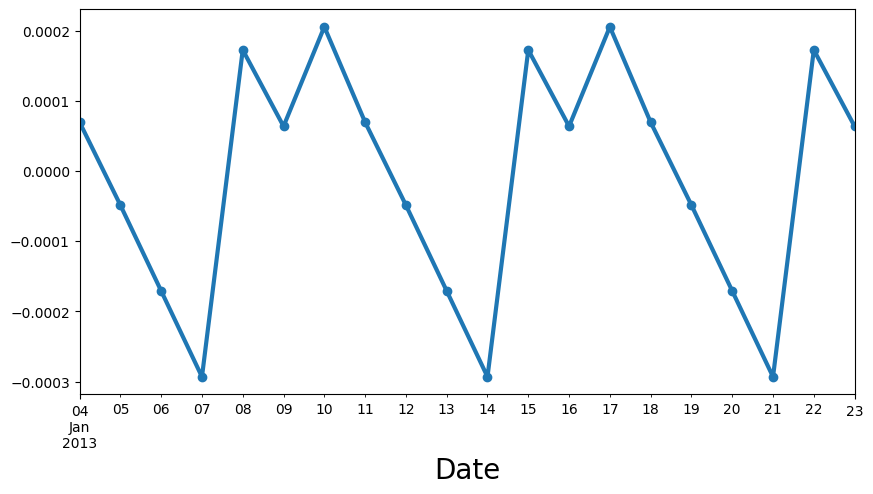

In [11]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

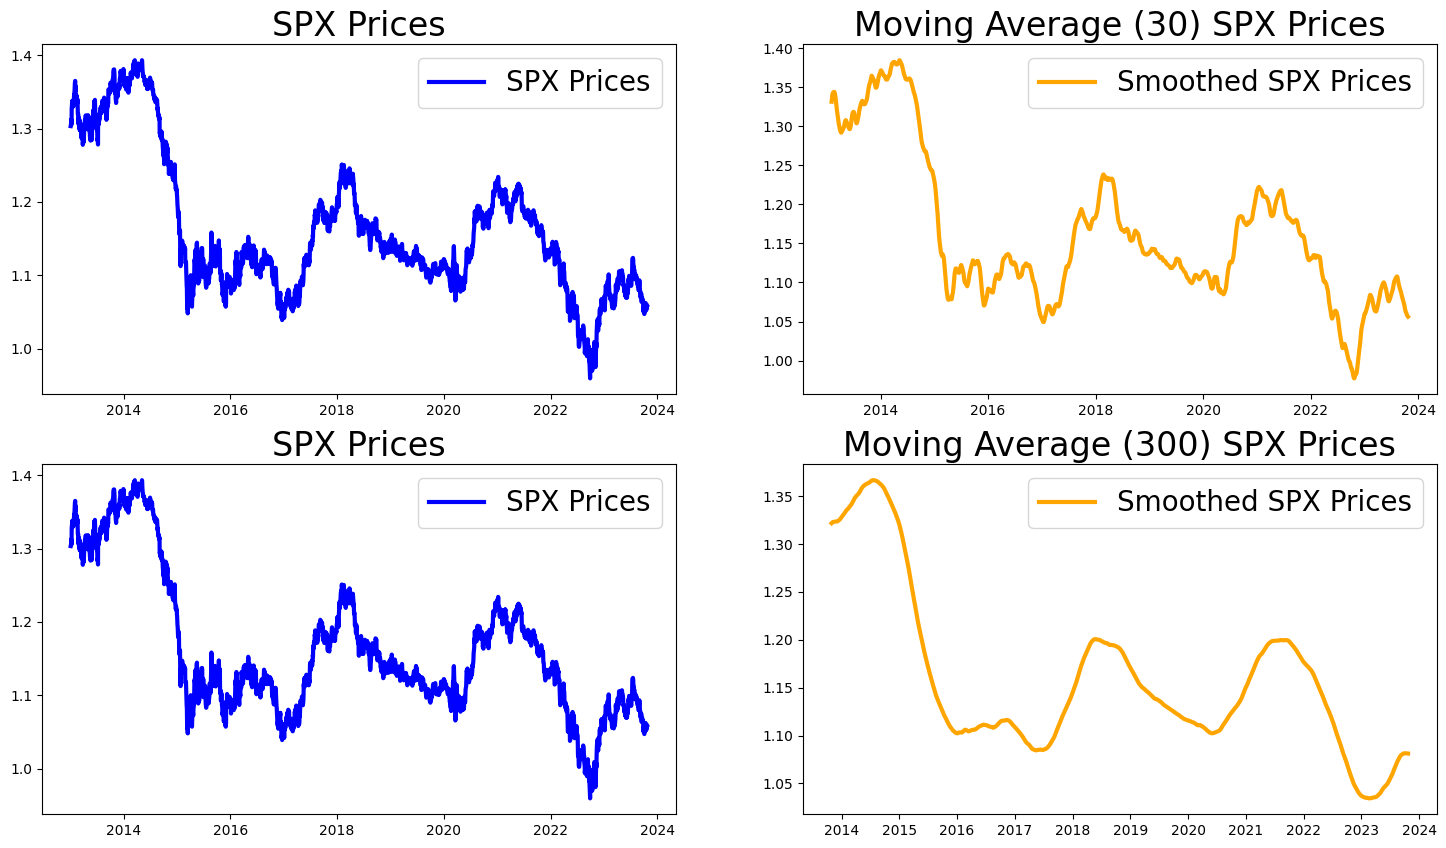

In [12]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.Close, color="blue", label="SPX Prices")
ax[0, 0].set_title("SPX Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.Close.rolling(window=30).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (30) SPX Prices", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.Close, color="blue", label="SPX Prices")
ax[1, 0].set_title("SPX Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.Close.rolling(window=300).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (300) SPX Prices", size=24)
ax[1, 1].legend()

plt.show()

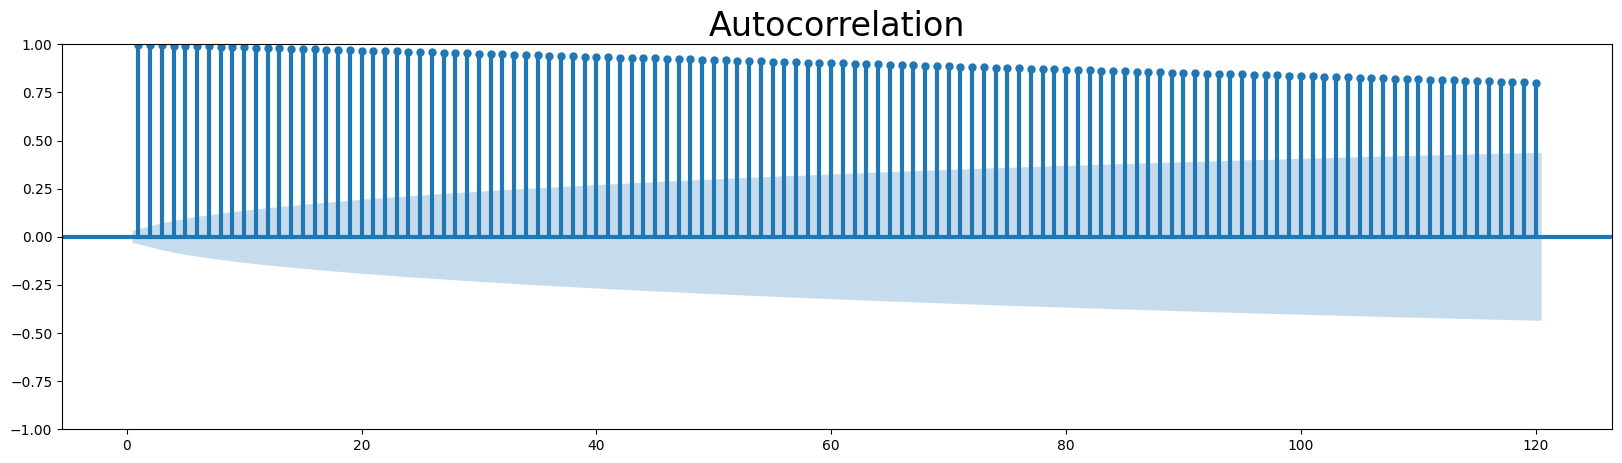

In [13]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.Close, lags=120, zero=False)
plt.show()

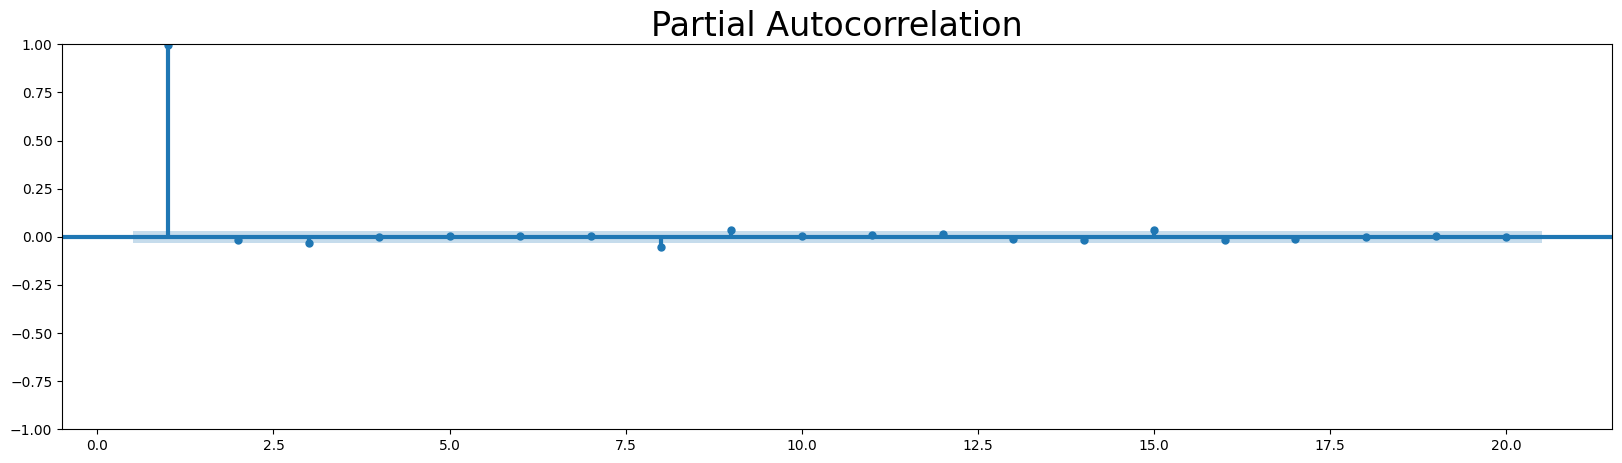

In [14]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.Close, lags=20, method="ywm", zero=False)
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["Close"])

(-1.7786099646511884,
 0.3911317627942993,
 14,
 3930,
 {'1%': -3.4320150321602574,
  '5%': -2.8622757200880744,
  '10%': -2.5671616322540127},
 -31293.62625801665)

In [16]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

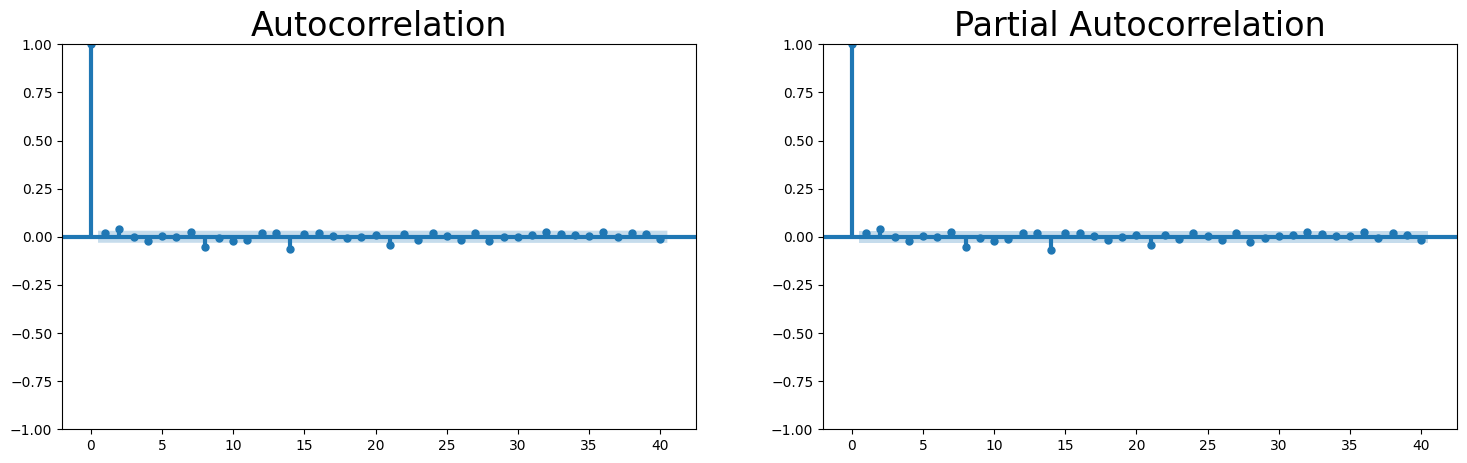

(-18.181621954036267,
 2.4321653213414987e-30,
 13,
 3930,
 {'1%': -3.4320150321602574,
  '5%': -2.8622757200880744,
  '10%': -2.5671616322540127},
 -31291.58244018646)

In [17]:
plot_acf_pacf(train_df["Close"].diff().dropna())
adfuller(train_df["Close"].diff().dropna())

Первые разности являются стационарными

In [141]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_df['Close'], trend='add', seasonal='add', seasonal_periods=7).fit()

In [142]:
test_predictions = fitted_model.forecast(len(test_df))
test_predictions

2023-10-24    1.059378
2023-10-25    1.059232
2023-10-26    1.059300
2023-10-27    1.059094
2023-10-28    1.058904
2023-10-29    1.058714
2023-10-30    1.058529
2023-10-31    1.058911
2023-11-01    1.058765
2023-11-02    1.058833
2023-11-03    1.058626
2023-11-04    1.058436
2023-11-05    1.058246
2023-11-06    1.058062
Freq: D, dtype: float64

<Axes: xlabel='Date'>

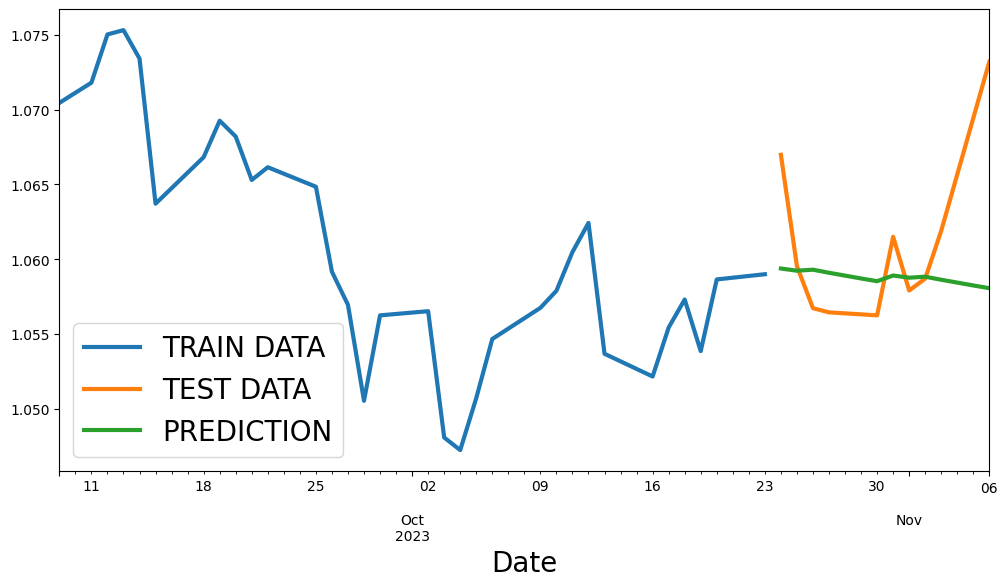

In [143]:
train_df[3900:]['Close'].plot(legend=True, label='TRAIN DATA')
test_df['Close'].plot(legend=True, label='TEST DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)
test_predictions.plot(legend=True, label='PREDICTION')

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_error = mean_absolute_error(test_df.Close, test_predictions)

print(f"Mean absolute error of the above model is {mae_error}")

mse_error = mean_squared_error(test_df.Close, test_predictions)

print(f"Mean squared error of the above model is {mse_error}")

rmse_error = np.sqrt(mean_squared_error(test_df.Close, test_predictions))

print(f"Root mean squared error of the above model is {rmse_error}")

Mean absolute error of the above model is 0.00434258981299069
Mean squared error of the above model is 3.676457995222804e-05
Root mean squared error of the above model is 0.006063380241435303


In [22]:
from statsmodels.tsa.ar_model import AutoReg

mod1 = AutoReg(train_df['Close'], 1, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 3945
Model:                     AutoReg(1)   Log Likelihood               15755.461
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Tue, 07 Nov 2023   AIC                         -31504.923
Time:                        12:48:29   BIC                         -31486.083
Sample:                    01-05-2013   HQIC                        -31498.240
                         - 10-23-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.583      0.113      -0.000       0.003
Close.L1       0.9988      0.001   1331.196      0.000       0.997       1.000
                                    Roots           

In [23]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions1 = res1.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

<Axes: xlabel='Date'>

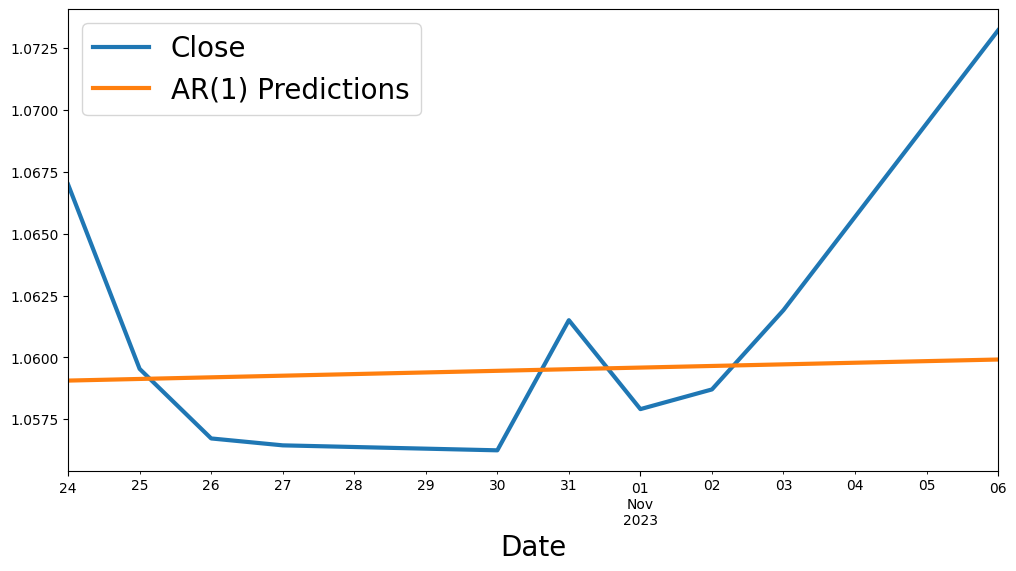

In [24]:
test_df['Close'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))

In [145]:
mod14 = AutoReg(train_df['Close'], len(test_df))
res14 = mod14.fit()
print(res14.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 3945
Model:                    AutoReg(14)   Log Likelihood               15727.771
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Tue, 07 Nov 2023   AIC                         -31423.542
Time:                        13:55:05   BIC                         -31323.115
Sample:                    01-18-2013   HQIC                        -31387.912
                         - 10-23-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.734      0.083      -0.000       0.003
Close.L1       1.0184      0.016     63.866      0.000       0.987       1.050
Close.L2       0.0207      0.023      0.908      0.3

In [146]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions14 = res14.predict(start=start, end=end, dynamic=False).rename('AR(14) Predictions')

<Axes: xlabel='Date'>

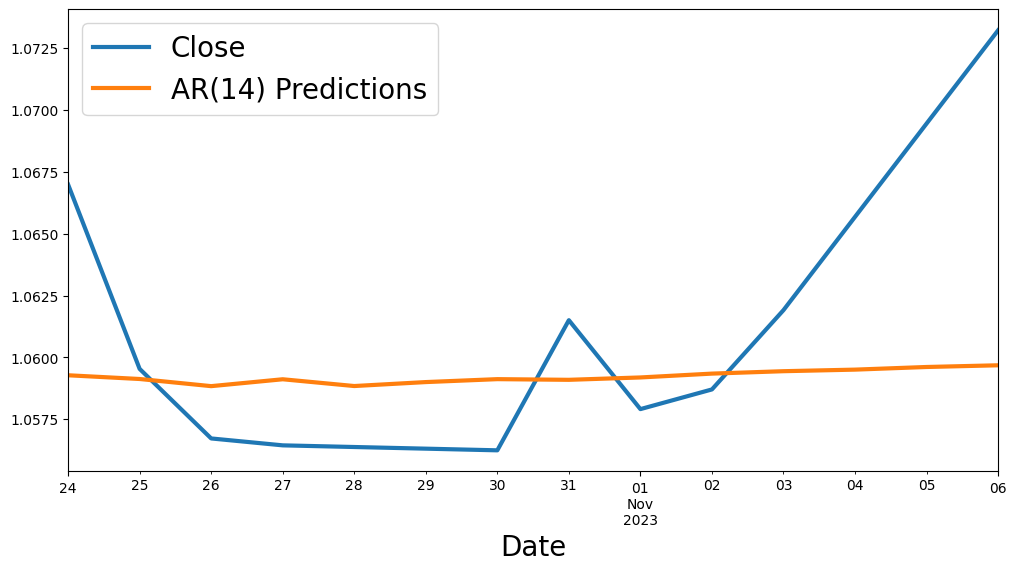

In [147]:
test_df['Close'].plot(legend=True)
predictions14.plot(legend=True,figsize=(12,6))

In [28]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(14)']
preds = [predictions1, predictions14]  # these are variables, not strings!

for i in range(2):
    error = mean_squared_error(test_df['Close'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 3.011720211e-05
AR(14) Error: 3.033332239e-05


In [29]:
modls = [res1,res14]

for i in range(2):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: -3.1505e+04
AR(14) AIC: -3.1424e+04


In [30]:
#!pip install pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df['Close'],
    start_p=0,
    d=1,
    start_q=0,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    seasonal = True,
    trace=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31504.170, Time=1.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31503.668, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31503.558, Time=2.55 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31505.408, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31503.238, Time=3.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.885 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3945
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15753.704
Date:                Tue, 07 Nov 2023   AIC                         -31505.408
Time:                        12:49:02   BIC                         -31499.128
Sample:                    01-04-2013   HQIC                        -31503.180
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.986e-05   2.22e-07     89.379      0.000    1.94e-05    2.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              6167.64
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df['Close'],order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3945
Model:                 ARIMA(0, 1, 0)   Log Likelihood               15753.704
Date:                Tue, 07 Nov 2023   AIC                         -31505.408
Time:                        13:55:23   BIC                         -31499.128
Sample:                    01-04-2013   HQIC                        -31503.180
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.986e-05   2.22e-07     89.379      0.000    1.94e-05    2.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              6167.64
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(0,1,0) Predictions')

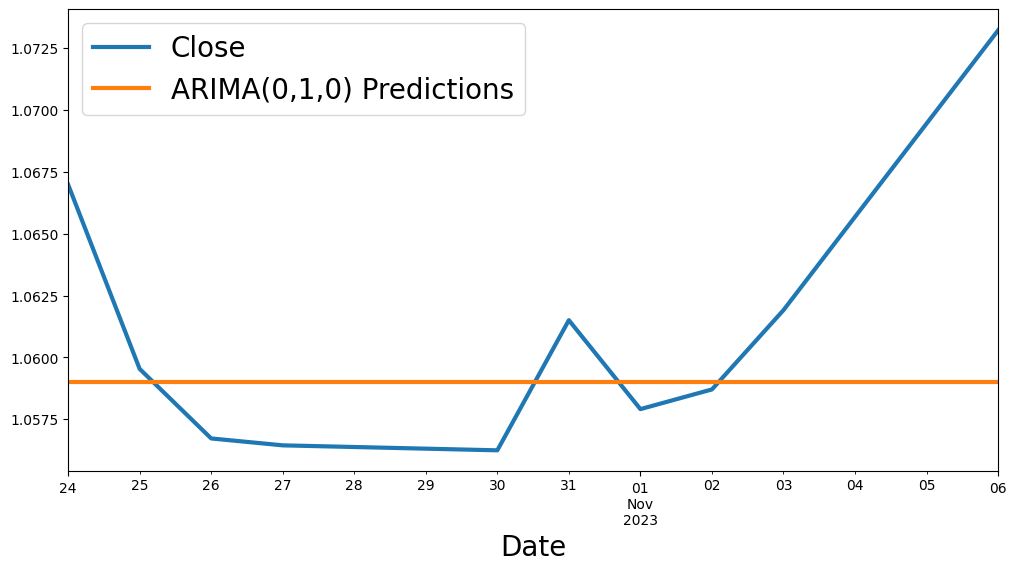

In [150]:
ax = test_df['Close'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [34]:
error = mean_squared_error(test_df['Close'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')

from statsmodels.tools.eval_measures import rmse

error = rmse(test_df['Close'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error: 3.353043767e-05
ARIMA(0,1,0) RMSE Error: 0.005790547269


In [37]:
smodel = pm.auto_arima(
    train_df['Close'],
    start_p=0,
    d=1,
    start_q=0,
    max_p=3,
    max_q=3,
    D=None,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    test="adf",
    error_action="ignore",
    seasonal = True,
    trace=True,
    suppress_warnings = True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-31504.170, Time=0.45 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-31504.405, Time=2.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-31504.495, Time=4.40 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-31505.408, Time=0.42 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-31504.678, Time=3.37 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-31504.906, Time=1.77 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-31503.155, Time=4.68 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-31503.668, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-31503.558, Time=3.34 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-31503.238, Time=3.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 24.055 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3945
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15753.704
Date:                Tue, 07 Nov 2023   AIC                         -31505.408
Time:                        12:57:21   BIC                         -31499.128
Sample:                    01-04-2013   HQIC                        -31503.180
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.986e-05   2.22e-07     89.379      0.000    1.94e-05    2.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              6167.64
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_df['Close'],order=(0,1,0),seasonal_order=(0,1,0,7))
results = model.fit()
results.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 3945
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               14415.955
Date:                           Tue, 07 Nov 2023   AIC                         -28829.909
Time:                                   13:55:40   BIC                         -28823.631
Sample:                               01-04-2013   HQIC                        -28827.682
                                    - 10-23-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.86e-05   4.62e-07     83.562      0.000    3.77e-05    3.95e-05
===================================================================================
Ljung-Box (L1) (Q):                   9.77   Jarque-Bera (JB):              4244.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
start=len(train_df)
end=len(train_df)+len(test_df)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1)(0,1,0,7) Predictions')

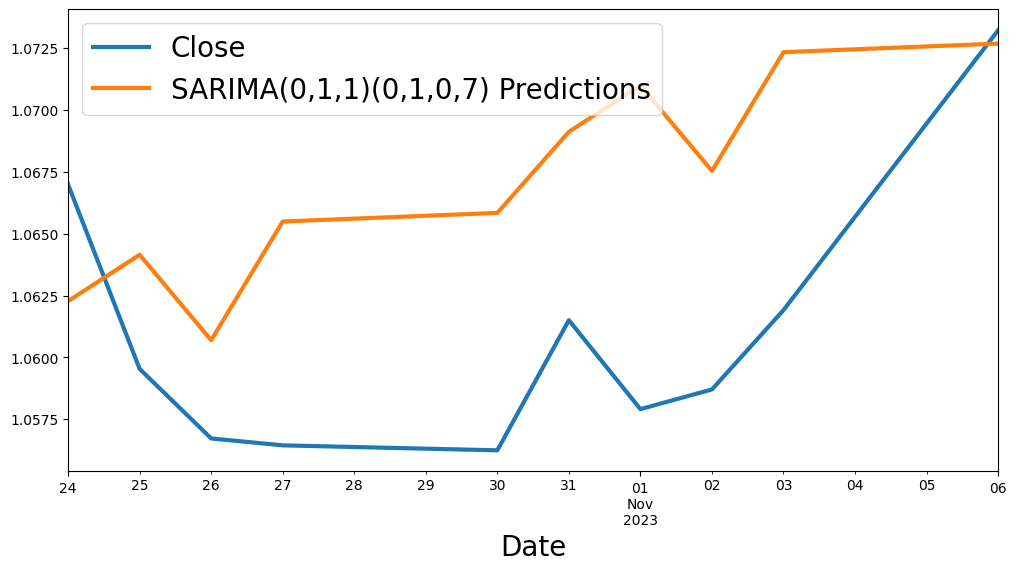

In [153]:
ax = test_df['Close'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [73]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_df['Close'], predictions)
print(f'ARIMA(0,1,0) MSE Error: {error:11.10}')

from statsmodels.tools.eval_measures import rmse

error = rmse(test_df['Close'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) MSE Error: 6.272360342e-05
ARIMA(0,1,0) RMSE Error: 0.007919823447


In [74]:
#!pip install requests
import requests
url = 'https://economic-calendar.tradingview.com/events'
today = pd.Timestamp.today().normalize()
payload = {
    'from': (today - pd.offsets.Day(4000)).isoformat() + '.000Z',
    'to': (today + pd.offsets.Day(15)).isoformat() + '.000Z',
    'countries': ','.join(['US', 'EU']),
    'minImportance' : 1,
}
dataset = requests.get(url, params=payload).json()

In [154]:
df = pd.DataFrame(dataset['result'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1607 non-null   object 
 1   title       1607 non-null   object 
 2   country     1607 non-null   object 
 3   indicator   1607 non-null   object 
 4   ticker      1450 non-null   object 
 5   comment     1503 non-null   object 
 6   period      1607 non-null   object 
 7   source      1607 non-null   object 
 8   actual      1404 non-null   float64
 9   previous    1419 non-null   float64
 10  forecast    1402 non-null   float64
 11  currency    1607 non-null   object 
 12  importance  1607 non-null   int64  
 13  date        1607 non-null   object 
 14  scale       332 non-null    object 
 15  unit        1009 non-null   object 
dtypes: float64(3), int64(1), object(12)
memory usage: 201.0+ KB


In [76]:
df

,id,title,country,indicator,ticker,comment,period,source,actual,previous,forecast,currency,importance,date,scale,unit
0,4361,Non Farm Payrolls,US,Non Farm Payrolls,USNFP,Nonfarm payrolls is an employment report relea...,DEC 2012,Bureau of Labour Statistics,NaN,NaN,NaN,USD,1,2013-01-04T13:30:00.000Z,NaN,NaN
1,4362,Non Farm Payrolls,US,Non Farm Payrolls,USNFP,Nonfarm payrolls is an employment report relea...,JAN 2013,Bureau of Labour Statistics,NaN,NaN,NaN,USD,1,2013-02-01T13:30:00.000Z,NaN,NaN
2,8510,Fed Lockhart speech,US,Calendar,NaN,NaN,,,NaN,NaN,NaN,USD,1,2013-02-26T00:00:00.000Z,NaN,NaN
3,8520,Consumer Confidence,US,Calendar,NaN,NaN,,,NaN,58.600,61.00,USD,1,2013-02-26T15:00:00.000Z,NaN,NaN
4,6428,Business Confidence,EU,Business Confidence,EUBCOI,The Business Climate Indicator (BCI) is calcul...,Feb 2013,European Commission,NaN,-0.730,NaN,EUR,1,2013-02-27T10:00:00.000Z,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,330421,Inflation Rate YoY,US,Inflation Rate,USIRYY,"In the United States, unadjusted Consumer Pric...",Oct,Bureau of Labour Statistics,NaN,3.700,NaN,USD,1,2023-11-14T13:30:00.000Z,NaN,%
1603,330422,Core Inflation Rate YoY,US,Core Inflation Rate,USCIR,"In the United States, the core inflation rate ...",Oct,Bureau of Labour Statistics,NaN,4.100,NaN,USD,1,2023-11-14T13:30:00.000Z,NaN,%
1604,330591,PPI MoM,US,Producer Price Inflation MoM,USPPIMM,"In the United States, the Producer Price Infla...",Oct,Bureau of Labour Statistics,NaN,0.500,0.10,USD,1,2023-11-15T13:30:00.000Z,NaN,%
1605,330669,Retail Sales MoM,US,Retail Sales MoM,USRSMM,Retail sales report in the US provides aggrega...,Oct,Census Bureau,NaN,0.700,0.00,USD,1,2023-11-15T13:30:00.000Z,NaN,%


In [155]:
df['date'] = pd.to_datetime(df['date']).dt.date
df.drop(['id', 'source', 'comment', 'unit', 'scale', 'period', 'currency', 'ticker', 'indicator', 'country'], axis= 1 , inplace= True )



In [156]:
# преобразование данных
df_encoded = df.pivot_table(columns='title', index='date', values='importance', fill_value=0).reset_index().rename_axis(None, axis=1).set_index('date')
df_encoded = df_encoded.asfreq(freq='d')
df_encoded = df_encoded.fillna(0)

In [157]:
exog = train_df.merge(df_encoded, how='left', left_index=True, right_index=True ).fillna(0).drop(['Close'], axis= 1)

In [80]:
exog

,Balance of Trade,Building Permits,Building Permits Prel,Business Confidence,Closed-door Fed Emergency Meeting,Conference Call on Emergency Lending to Greek Banks,Consumer Confidence,Consumer Price Index Ex Food & Energy (MoM),Consumer Price Index Ex Food & Energy (YoY),Continuing Jobless Claims,...,President Trump Speech,President Trump Statement on Coronavirus,Presidential Election,Retail Sales MoM,Reuters/Michigan Consumer Sentiment Index,Sentix Investors Sentiment,Treasury Secretary Yellen Senate Confirmation Hearing,US-China Phase 1 Trade Deal Signature,USMCA Trade Deal Signature,Unemployment Rate
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df['Close'],
    start_p=0,
    d=1,
    start_q=0,
    max_p=3,
    max_q=3,
    D=None,
    start_P=0,
    start_Q=0,
    max_P=3,
    max_Q=3,
    m=7,
    test="adf",
    error_action="ignore",
    exogenous=exog,
    seasonal = True,
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-31504.170, Time=0.45 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-31504.405, Time=1.98 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-31504.495, Time=5.48 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-31505.408, Time=0.24 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-31504.678, Time=2.57 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-31504.906, Time=1.70 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-31503.155, Time=4.47 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-31503.668, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-31503.558, Time=3.61 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-31503.238, Time=3.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 23.949 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3945
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15753.704
Date:                Tue, 07 Nov 2023   AIC                         -31505.408
Time:                        13:13:30   BIC                         -31499.128
Sample:                    01-04-2013   HQIC                        -31503.180
                         - 10-23-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.986e-05   2.22e-07     89.379      0.000    1.94e-05    2.03e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):              6167.64
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [159]:
seas_model = SARIMAX(
    train_df["Close"].dropna(), exog=exog,
    order=(0, 1, 0), seasonal_order=(0, 1, 0, 7)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 3945
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               14532.685
Date:                           Tue, 07 Nov 2023   AIC                         -28863.369
Time:                                   14:04:25   BIC                         -28229.274
Sample:                               01-04-2013   HQIC                        -28638.418
                                    - 10-23-2023                                         
Covariance Type:                             opg                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Balance of Trade                                                  0.0003      0.000      1.379      0.168      -0.000       0.001
Building Permits                                                 -0.0020      0.001     -3.063      0.002      -0.003      -0.001
Building Permits Prel                                             0.0006      0.001      0.628      0.530      -0.001       0.002
Business Confidence                                              -0.0006      0.000     -2.245      0.025      -0.001   -7.59e-05
Closed-door Fed Emergency Meeting                                 0.0008      0.008      0.102      0.918      -0.014       0.016
Conference Call on Emergency Lending to Greek Banks              -0.0013      0.002     -0.699      0.485      -0.005       0.002
Consumer Confidence                                              -0.0072      0.006     -1.140      0.254      -0.020       0.005
Consumer Price Index Ex Food & Energy (MoM)                       0.0041      0.002      2.112      0.035       0.000       0.008
Consumer Price Index Ex Food & Energy (YoY)                       0.0041      0.002      2.112      0.035       0.000       0.008
Continuing Jobless Claims                                         0.0016      0.001      2.031      0.042    5.44e-05       0.003
Core Durable Goods Orders MoM                                    -0.0057      0.006     -0.953      0.341      -0.017       0.006
Core Inflation Rate MoM                                          -0.0003      0.002     -0.199      0.842      -0.003       0.003
Core Inflation Rate YoY                                           0.0060      0.002      2.560      0.010       0.001       0.011
Core PCE Price Index MoM                                          0.0016      0.002      0.914      0.361      -0.002       0.005
Deadline for Greece to Enact Reforms                              0.0033      0.003      1.203      0.229      -0.002       0.009
Deadline on Detailed Proposal on Economic Reforms from Greece     0.0049      0.003      1.519      0.129      -0.001       0.011
Deposit Facility Rate                                            -0.0053      0.004     -1.229      0.219      -0.014       0.003
Durable Goods Orders MoM                                       6.553e-05      0.000      0.262      0.793      -0.000       0.001
ECB Forum on Central Banking                                      0.0039      0.003      1.434      0.152      -0.001       0.009
ECB Interest Rate Decision                                        0.0097      0.009      1.138      0.255      -0.007       0.026
ECB Macroeconomic Projections                                    -0.0050      0.003     -1.985      0.047      -0.010   -6.32e-05
ECB Monetary Policy St

In [160]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1], exog=df_encoded[-25:-11]
)


pred_df["Close"] = data["Close"]

forecast = seas_model_fit.get_forecast(len(test_df.index), exog=df_encoded[-25:-11]
                                       )
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Close"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Close"]

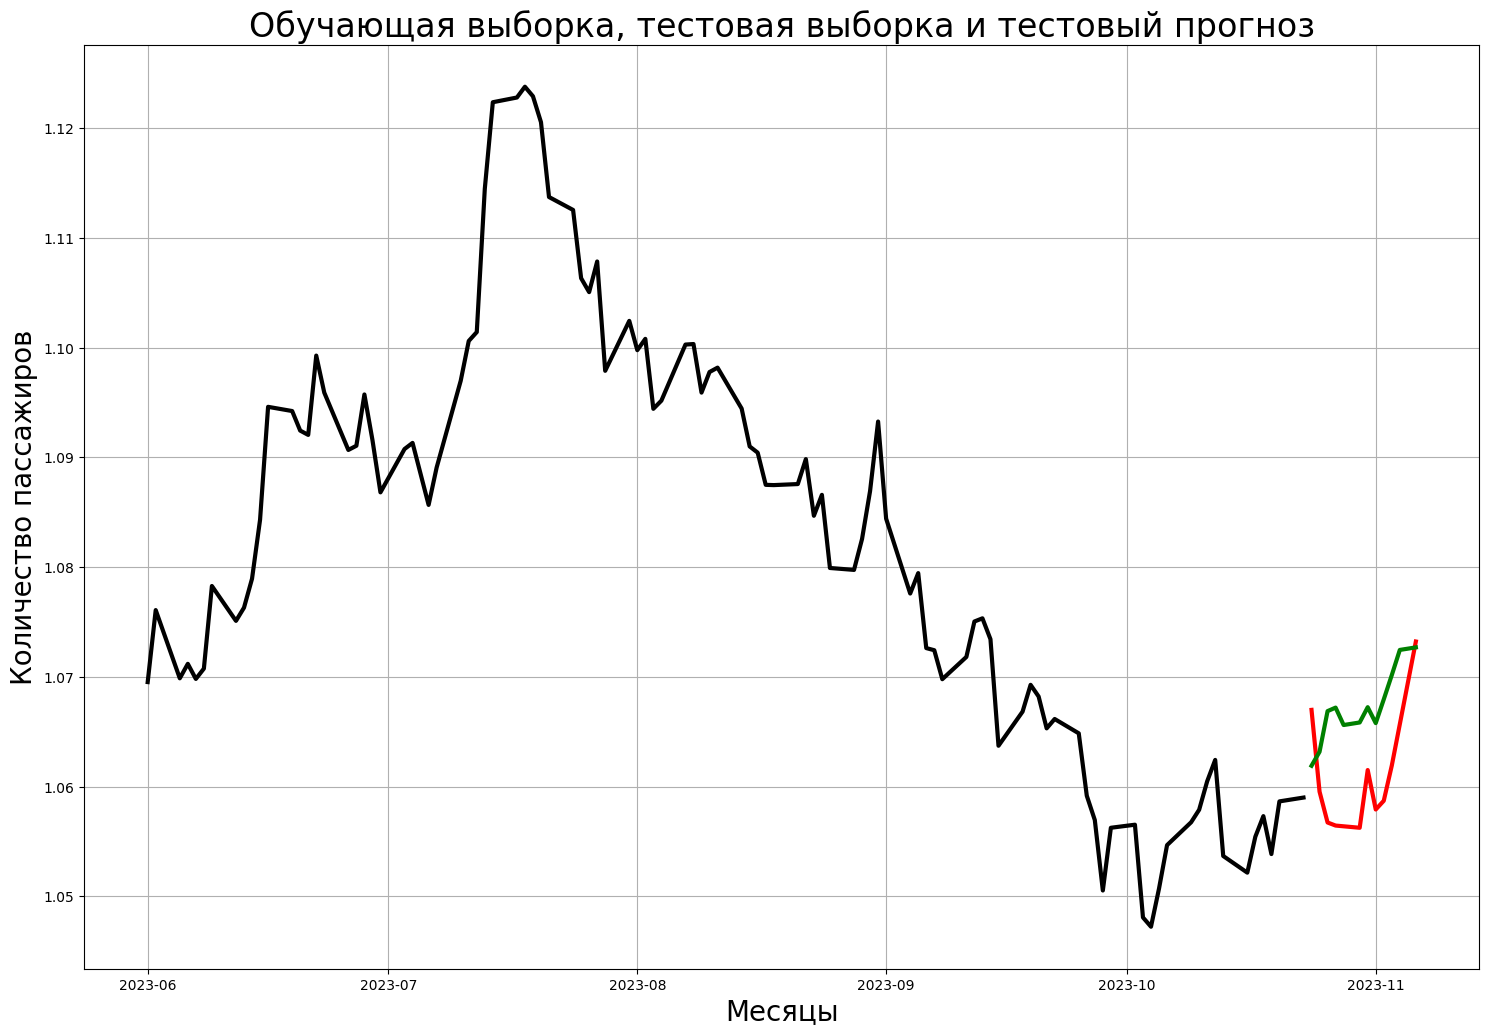

In [161]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train_df[3800:], color = "black")
plt.plot(test_df, color = "red")
plt.plot(pred_df["model_preds"], color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

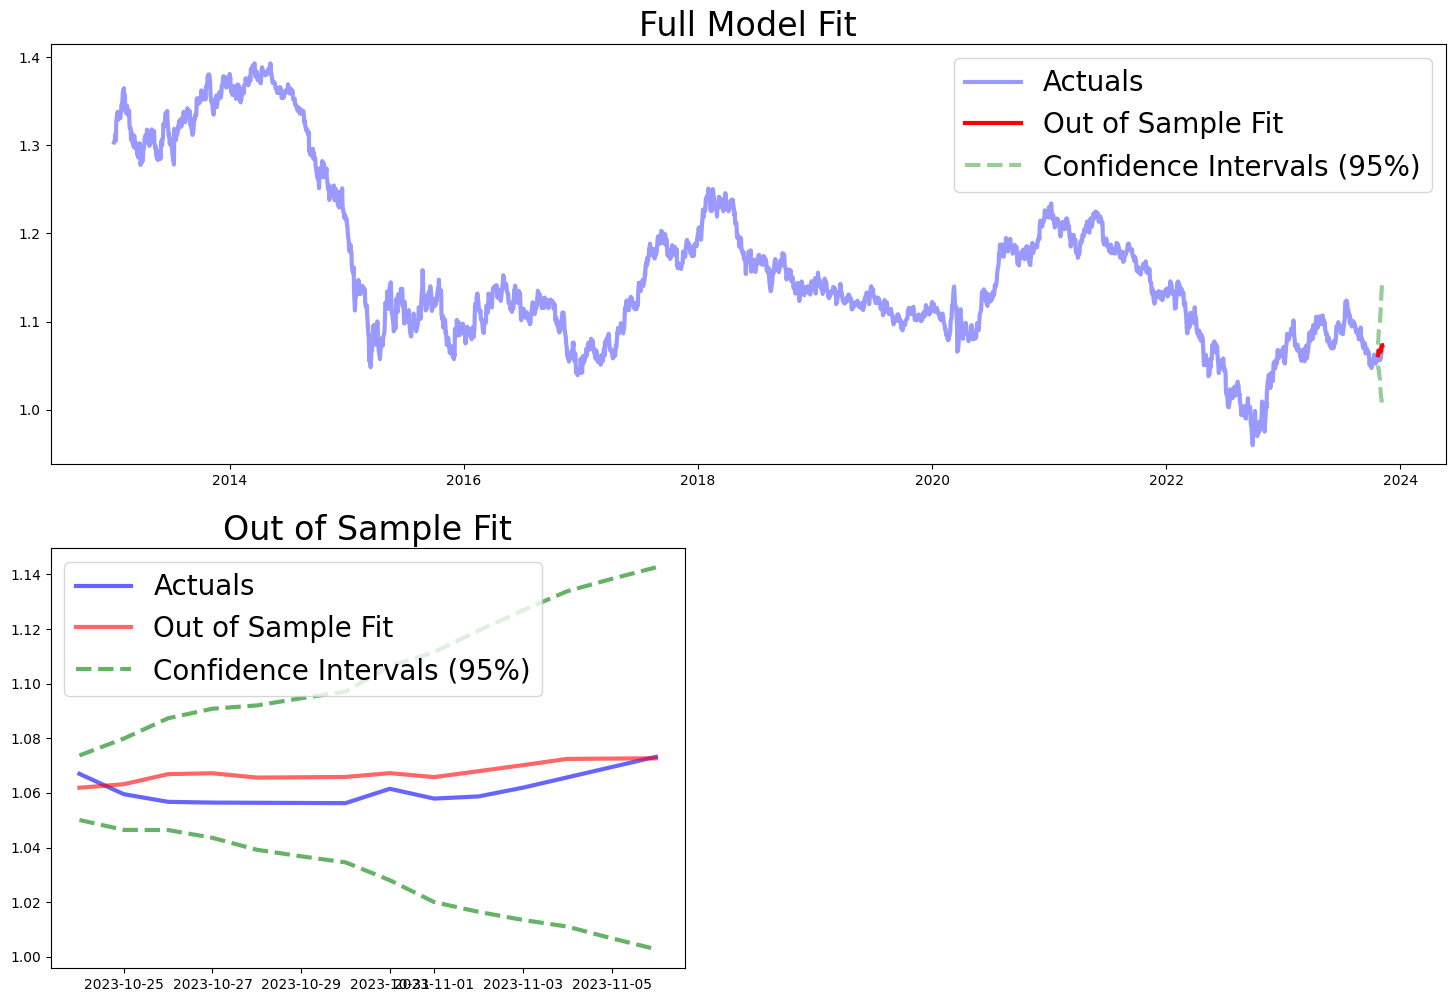

In [164]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["Close"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [165]:
seas_model = SARIMAX(
    data["Close"].dropna(), exog=df_encoded[:-11],
    order=(0, 1, 0), seasonal_order=(0, 1, 0, 7)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 3959
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               14588.148
Date:                           Tue, 07 Nov 2023   AIC                         -28974.295
Time:                                   14:08:36   BIC                         -28339.841
Sample:                               01-04-2013   HQIC                        -28749.257
                                    - 11-06-2023                                         
Covariance Type:                             opg                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Balance of Trade                                                  0.0003      0.000      1.389      0.165      -0.000       0.001
Building Permits                                                 -0.0020      0.001     -3.083      0.002      -0.003      -0.001
Building Permits Prel                                             0.0006      0.001      0.730      0.465      -0.001       0.002
Business Confidence                                              -0.0006      0.000     -2.241      0.025      -0.001   -7.49e-05
Closed-door Fed Emergency Meeting                                 0.0008      0.008      0.102      0.919      -0.014       0.016
Conference Call on Emergency Lending to Greek Banks              -0.0013      0.002     -0.699      0.485      -0.005       0.002
Consumer Confidence                                              -0.0072      0.006     -1.140      0.254      -0.020       0.005
Consumer Price Index Ex Food & Energy (MoM)                       0.0041      0.002      2.109      0.035       0.000       0.008
Consumer Price Index Ex Food & Energy (YoY)                       0.0041      0.002      2.109      0.035       0.000       0.008
Continuing Jobless Claims                                         0.0016      0.001      2.033      0.042    5.61e-05       0.003
Core Durable Goods Orders MoM                                    -0.0057      0.006     -0.954      0.340      -0.017       0.006
Core Inflation Rate MoM                                          -0.0004      0.002     -0.242      0.809      -0.003       0.003
Core Inflation Rate YoY                                           0.0060      0.002      2.566      0.010       0.001       0.011
Core PCE Price Index MoM                                          0.0014      0.002      0.820      0.412      -0.002       0.005
Deadline for Greece to Enact Reforms                              0.0033      0.003      1.203      0.229      -0.002       0.009
Deadline on Detailed Proposal on Economic Reforms from Greece     0.0049      0.003      1.520      0.128      -0.001       0.011
Deposit Facility Rate                                            -0.0048      0.004     -1.329      0.184      -0.012       0.002
Durable Goods Orders MoM                                       6.285e-05      0.000      0.252      0.801      -0.000       0.001
ECB Forum on Central Banking                                      0.0039      0.003      1.441      0.150      -0.001       0.009
ECB Interest Rate Decision                                        0.0092      0.008      1.123      0.261      -0.007       0.025
ECB Macroeconomic Projections                                    -0.0050      0.003     -1.985      0.047      -0.010   -6.34e-05
ECB Monetary Policy St

In [166]:
# прогнозный период с конца имеющихся данных
start = df_encoded.index[-11]
end = df_encoded.index[-1]
forecast = seas_model_fit.predict(start, end, exog=df_encoded[-11:])


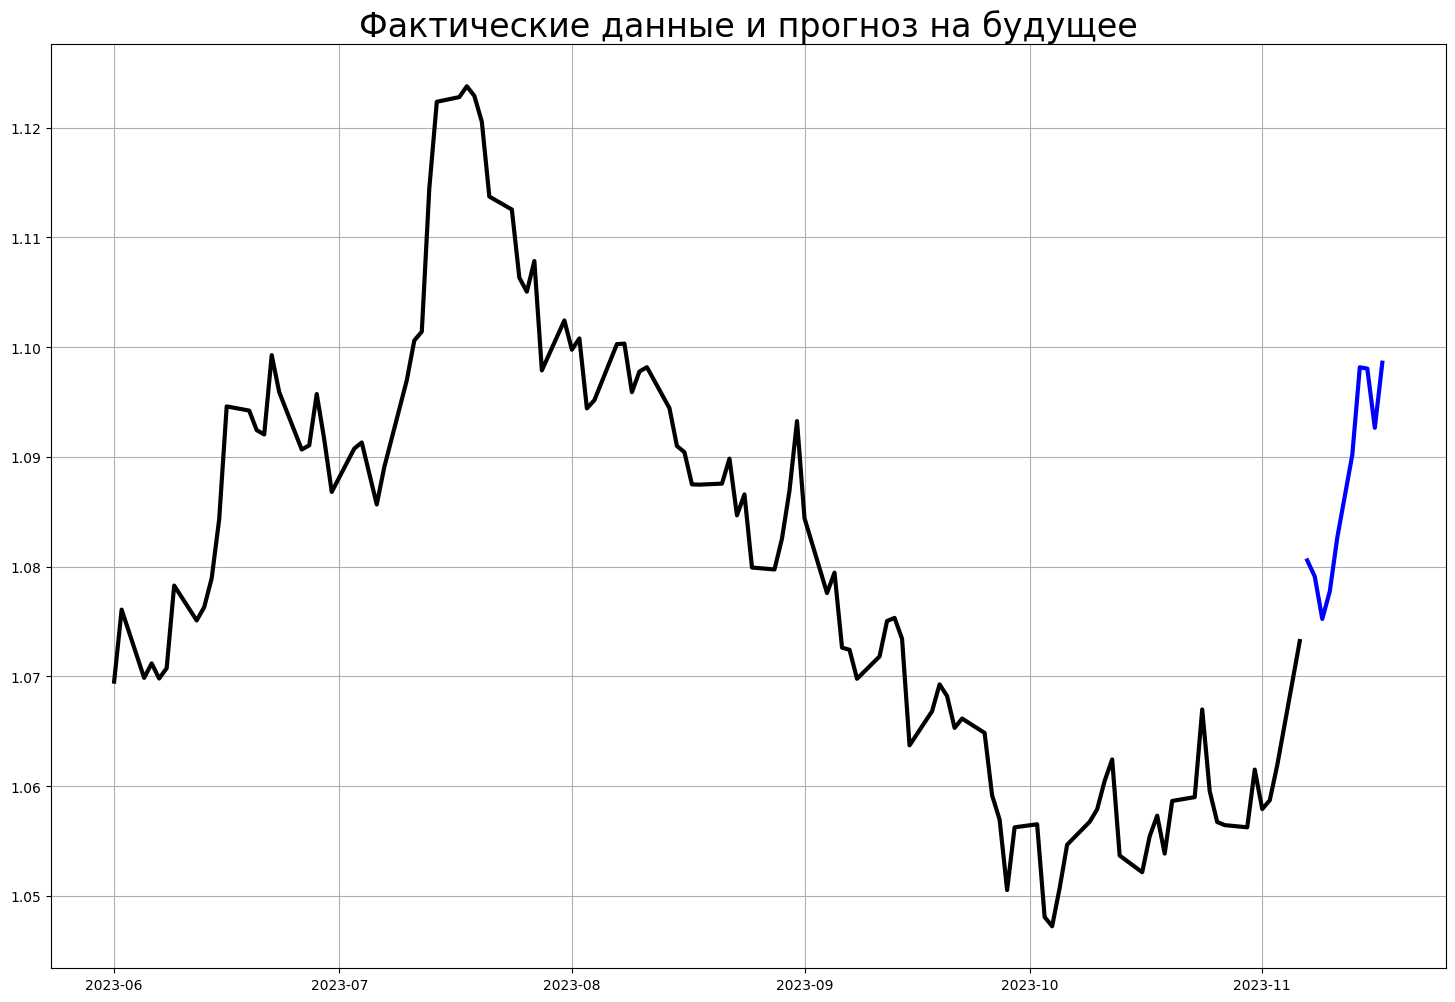

In [167]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(data[3800:], color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')


# добавим сетку
plt.grid()

plt.show()

In [169]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [170]:
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3762

In [171]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.7927961 ],
       [0.79546775],
       [0.79813941],
       ...,
       [0.24467447],
       [0.25336826],
       [0.26206206]])

In [172]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.7927961 , 0.79546775, 0.79813941, 0.80081107, 0.81410573,
       0.80424213, 0.79789896, 0.84826726, 0.85510013, 0.861933  ,
       0.86876588, 0.87243619, 0.85641753, 0.85233717, 0.87119809,
       0.86715733, 0.86311656, 0.8590758 , 0.85711249, 0.85768479,
       0.85641753, 0.87045555, 0.87788997, 0.88532439, 0.89275881,
       0.8882057 , 0.89866855, 0.91636342, 0.92620502, 0.92910503,
       0.93200504, 0.93490505, 0.90329454, 0.91938168, 0.90611892,
       0.87508072, 0.87345658, 0.87183245, 0.87020832, 0.87835144,
       0.88954088, 0.88778878, 0.8666667 , 0.86598156, 0.86529641,
       0.86461126, 0.86535104, 0.87657046, 0.84826726, 0.83008617,
       0.83020671, 0.83032726, 0.83044781, 0.80025967, 0.80045658,
       0.82007873, 0.79907876, 0.79577128, 0.79246379, 0.78915631])]
[0.793580159045332]

[array([0.7927961 , 0.79546775, 0.79813941, 0.80081107, 0.81410573,
       0.80424213, 0.79789896, 0.84826726, 0.85510013, 0.861933  ,
       0.86876588, 0.87243619, 0.8564

In [188]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3702/3702 [==============================] - 234s 61ms/step - loss: 9.1140e-04


In [190]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 0s 33ms/step


0.0044874521075238755

In [192]:
BATCH_SIZE = 1
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_test, scaled_data[training_data_len:, :]))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [193]:
model.fit(train_univariate, epochs=1,
                      steps_per_epoch=3702,
                      validation_data=val_univariate, validation_steps=10)

3702/3702 [==============================] - 282s 75ms/step - loss: 3.6583e-04 - val_loss: 2.4231e-04


In [194]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 0s 64ms/step


0.006004848353019225

In [180]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

1/1 [==============================] - 0s 66ms/step


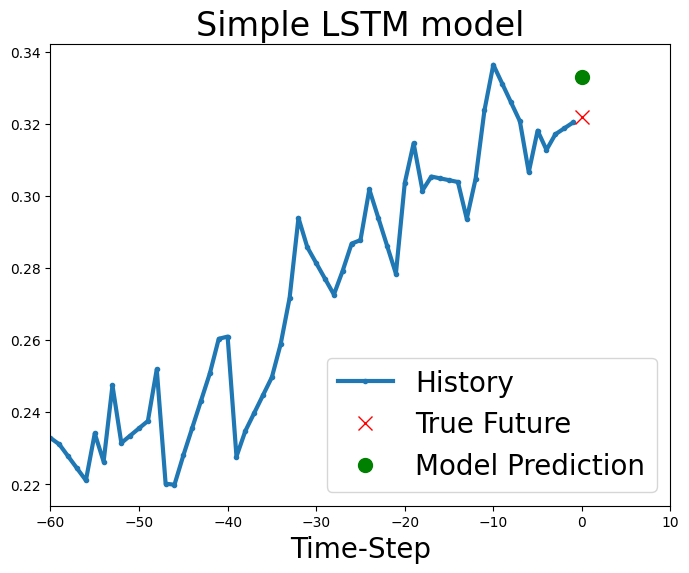

1/1 [==============================] - 0s 60ms/step


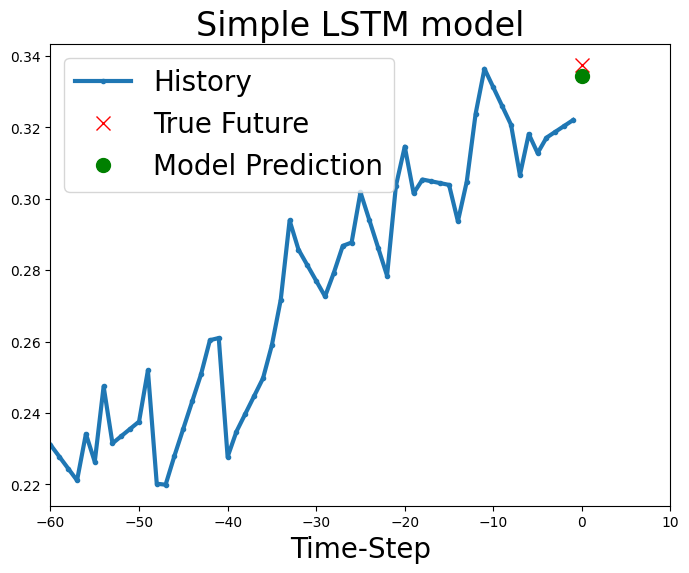

1/1 [==============================] - 0s 61ms/step


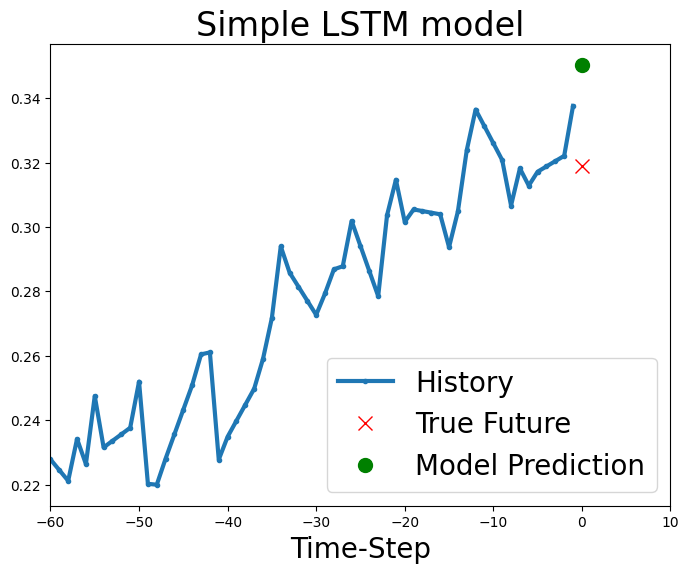

In [195]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [199]:
df_temp = data[-60:]
new_df = df_temp.filter(['Close'])

N = 60

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-60:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for EURUSD at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 87ms/step
The close price for EURUSD at 2023-11-07 was 1.07
The predicted close price is 1.0800000429153442 (+0.93%)


In [200]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [201]:
past_history = 60
future_target = 6
STEP = 1

x_train_single, y_train_single = multivariate_data(scaled_data, scaled_data[:, 0], 0,
                                                   3702, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(scaled_data, scaled_data[:, 0],
                                               3702, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (60, 1)


In [202]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [207]:
single_step_history = model.fit(train_data_single, epochs=1,
                                            steps_per_epoch=3702,
                                            validation_data=val_data_single,
                                            validation_steps=10)

3702/3702 [==============================] - 306s 83ms/step - loss: 0.0013 - val_loss: 1.9836e-04


1/1 [==============================] - 0s 44ms/step


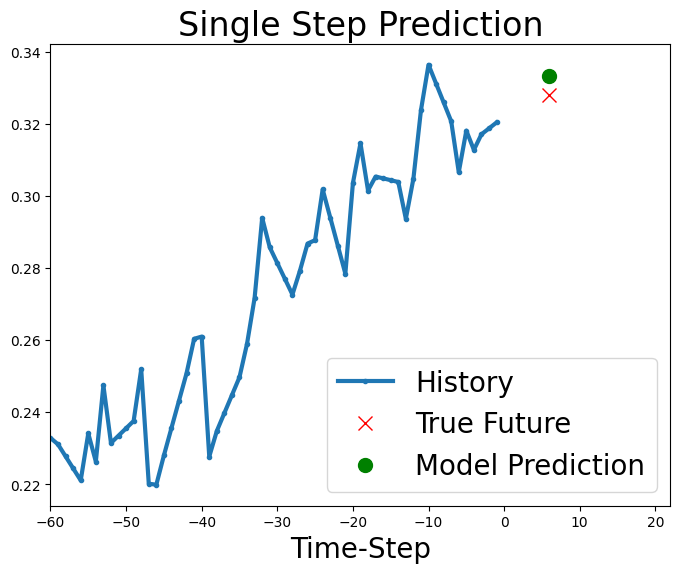

1/1 [==============================] - 0s 37ms/step


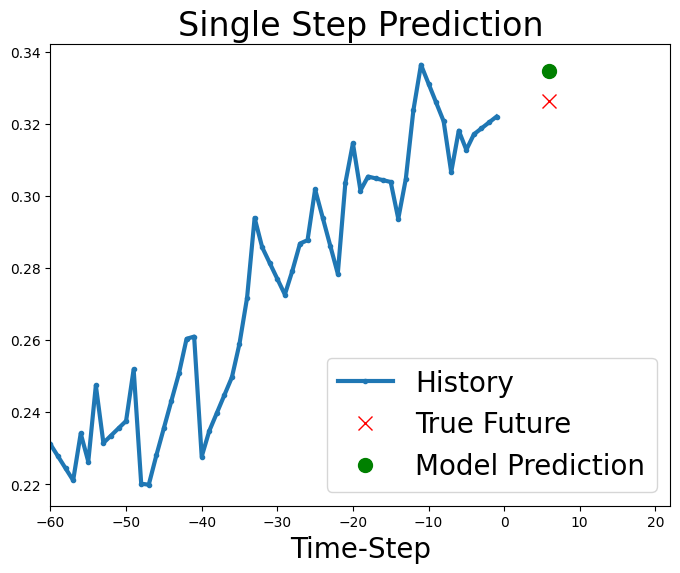

1/1 [==============================] - 0s 35ms/step


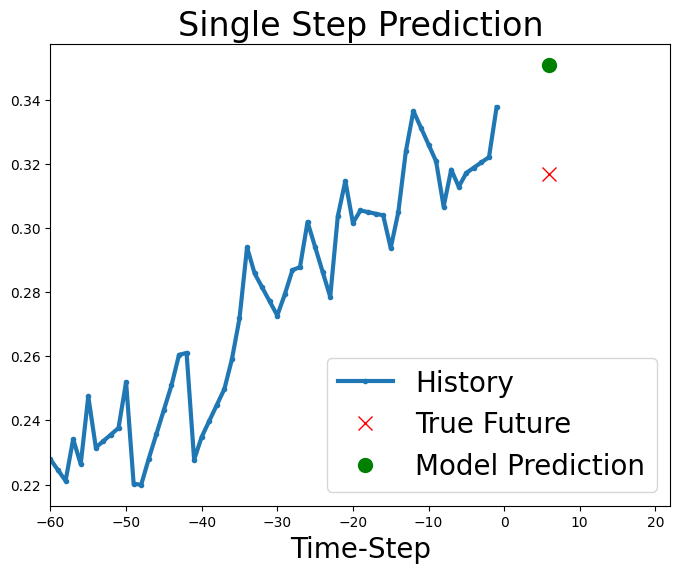

In [208]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 6,
                   'Single Step Prediction')
  plot.show()

In [209]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 0s 35ms/step


0.006937533833942364

In [210]:
past_history = 60
future_target = 6
x_train_multi, y_train_multi = multivariate_data(scaled_data, scaled_data[:, 0], 0,
                                                 3702, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(scaled_data, scaled_data[:, 0],
                                             3702, None, past_history,
                                             future_target, STEP)

In [211]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 1)

 Target temperature to predict : (6,)


In [212]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [213]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

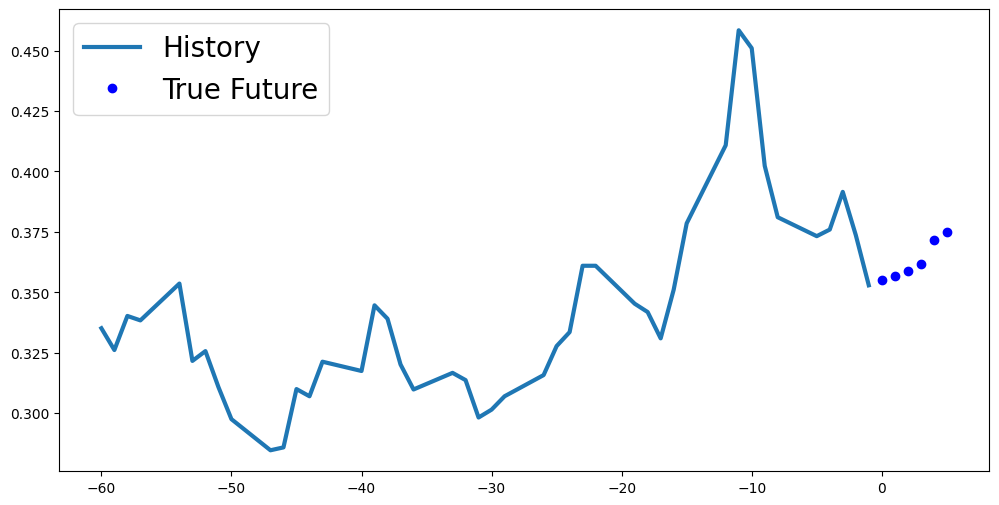

In [214]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [215]:
# Build the LSTM model
multi_model = Sequential()
multi_model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
multi_model.add(LSTM(64, return_sequences=False))
multi_model.add(Dense(25))
multi_model.add(Dense(6))

# Compile the model
multi_model.compile(optimizer='adam', loss='mean_squared_error')

In [216]:
multi_step_history = multi_model.fit(train_data_multi, epochs=2,
                                          steps_per_epoch=3702,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/2
3702/3702 [==============================] - 288s 76ms/step - loss: 0.0020 - val_loss: 3.1562e-04
Epoch 2/2
3702/3702 [==============================] - 274s 74ms/step - loss: 8.9427e-04 - val_loss: 1.5031e-04


In [217]:
predictions = multi_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 1s 39ms/step


0.00403698873435304

1/1 [==============================] - 1s 923ms/step


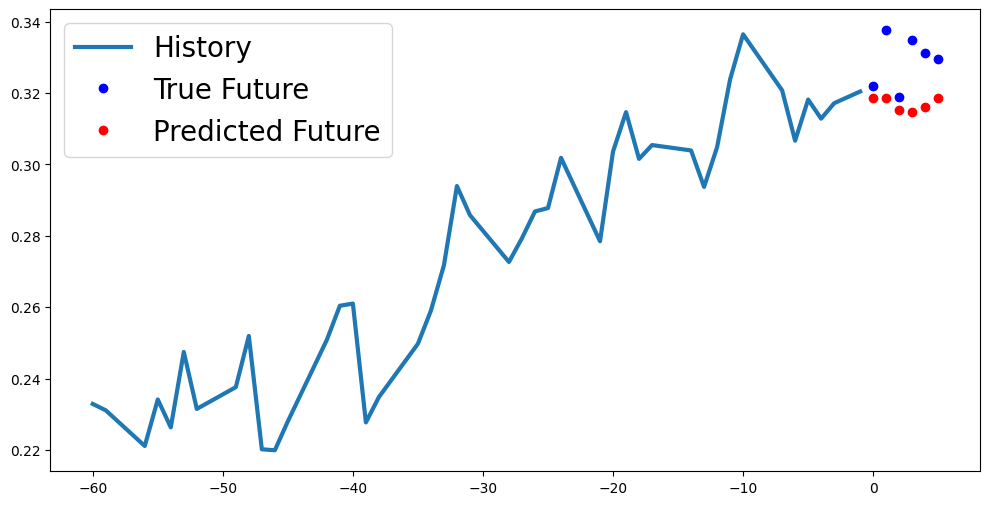

1/1 [==============================] - 0s 45ms/step


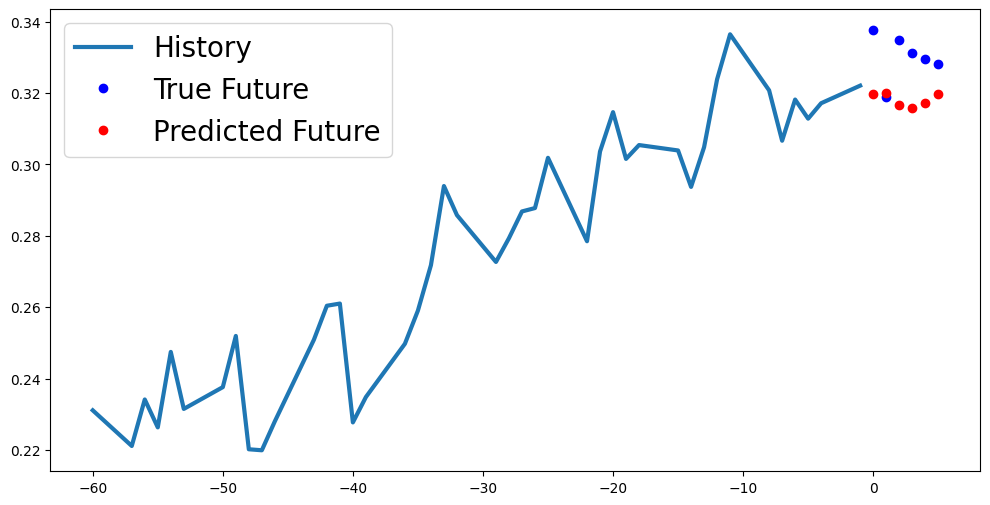

1/1 [==============================] - 0s 36ms/step


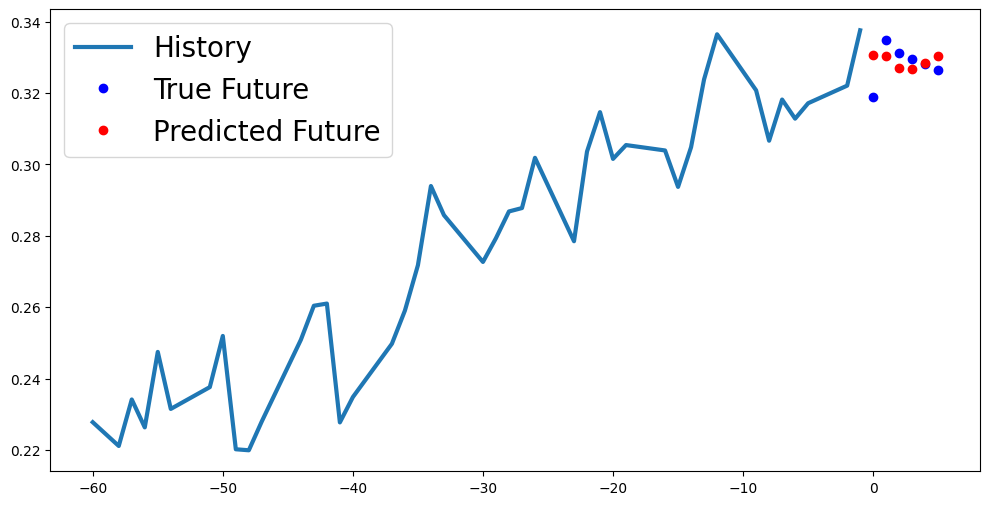

In [218]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_model.predict(x)[0])

In [219]:
# Create a new dataframe with only the 'Close column
data_new = data.merge(df_encoded, how='left', left_index=True, right_index=True ).fillna(0)
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

3762

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

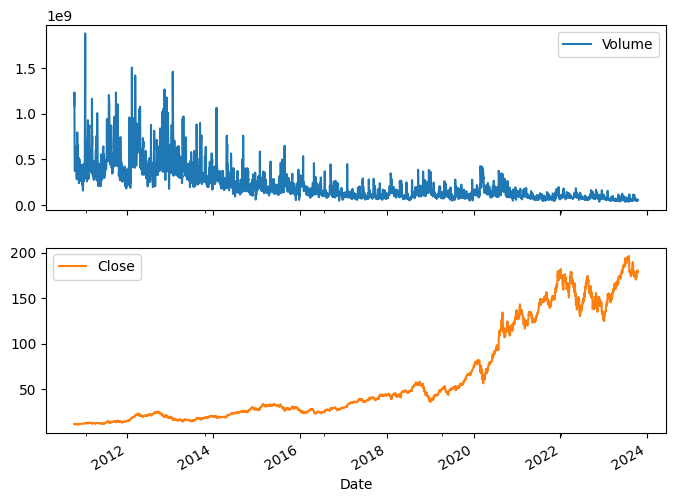

In [ ]:
data.plot(subplots=True)

In [221]:
# Scale the data

scaler_pred = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_pred.fit_transform(dataset)

scaled_data

array([[0.7927961 ],
       [0.79546775],
       [0.79813941],
       ...,
       [0.24467447],
       [0.25336826],
       [0.26206206]])

In [224]:
# Create the training data set
# Create the scaled training data set
index_Close = data.columns.get_loc("Close")
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, index_Close])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
print(x_train.shape, y_train.shape)


[array([[0.7927961 ],
       [0.79546775],
       [0.79813941],
       [0.80081107],
       [0.81410573],
       [0.80424213],
       [0.79789896],
       [0.84826726],
       [0.85510013],
       [0.861933  ],
       [0.86876588],
       [0.87243619],
       [0.85641753],
       [0.85233717],
       [0.87119809],
       [0.86715733],
       [0.86311656],
       [0.8590758 ],
       [0.85711249],
       [0.85768479],
       [0.85641753],
       [0.87045555],
       [0.87788997],
       [0.88532439],
       [0.89275881],
       [0.8882057 ],
       [0.89866855],
       [0.91636342],
       [0.92620502],
       [0.92910503],
       [0.93200504],
       [0.93490505],
       [0.90329454],
       [0.91938168],
       [0.90611892],
       [0.87508072],
       [0.87345658],
       [0.87183245],
       [0.87020832],
       [0.87835144],
       [0.88954088],
       [0.88778878],
       [0.8666667 ],
       [0.86598156],
       [0.86529641],
       [0.86461126],
       [0.86535104],
       [0.87

In [226]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3702/3702 [==============================] - 216s 57ms/step - loss: 0.0012


In [228]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_train.shape[2] ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

7/7 [==============================] - 1s 35ms/step


0.005092525894356653

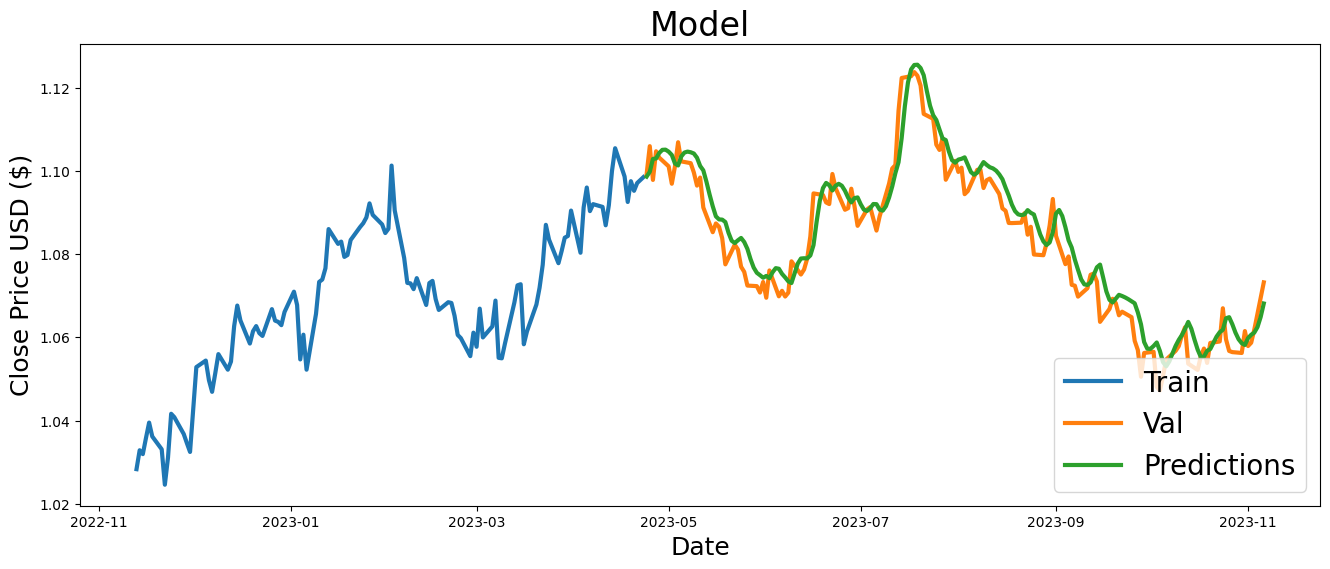

In [237]:
# Plot the data
train = data[3600:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,Volume,Open,Predictions
Date,,,
2023-02-23,48394200,150.089996,148.238007
2023-02-24,55469600,147.110001,148.753387
2023-02-27,44998500,147.710007,147.054367
2023-02-28,50547000,147.050003,146.948212
2023-03-01,55479000,146.830002,146.543320
...,...,...,...
2023-10-10,43698000,178.100006,173.394455
2023-10-11,47551100,178.199997,174.792877
2023-10-12,56743100,180.070007,175.038208


In [ ]:
new_df = data_new[-60:]

N = 60

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-60:].values
last_N_days_scaled = scaler_pred.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Open'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for EURUSD at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 47ms/step
The close price for Apple at 2023-10-17 was 176.75
The predicted close price is 174.61000061035156 (-1.23%)
